In [2]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf
import nlpbasic.text_summarize as txtsmr
import nlpbasic.word_embedding as wdembd

import model_explain.plot as meplot
import model_explain.shap as meshap

import data_visualization.distribution_plot as dbplot

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
import pycountry
import seaborn as sns
import plotly.express as px

import matplotlib
import matplotlib.dates as mdates


data_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

# https://www.kaggle.com/datajameson/topic-modelling-nlp-amazon-reviews-bbc-news

## Prepare Dataset

In [6]:
dataset = pd.read_csv(os.path.join(data_path, 'taylor_swift_lyrics.csv'))
dataset.head(3)

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006


In [11]:
def processFirstLine(lyrics, songID, songName, row):
    lyrics.append(row['lyric'] + '.\n')
    songID.append( row['year']*100+ row['track_n'])
    songName.append(row['track_title'])
    return lyrics,songID,songName
# define empty lists for the lyrics , songID , songName 
lyrics = []
songID = []
songName = []

# songNumber indicates the song number in the dataset
songNumber = 1

# i indicates the song number
i = 0
isFirstLine = True

# Iterate through every lyrics line and join them together for each song independently 
for index,row in dataset.iterrows():
    if(songNumber == row['track_n']):
        if (isFirstLine):
            lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
            isFirstLine = False
        else :
            #if we still in the same song , keep joining the lyrics lines    
            lyrics[i] +=  row['lyric'] + '.\n'
    #When it's done joining a song's lyrics lines , go to the next song :    
    else :
        lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
        songNumber = row['track_n']
        i+=1

# Define a new pandas DataFrame to save songID , songName , Lyrics in it to use them later
lyrics_data = pd.DataFrame({'songID':songID, 'songName':songName, 'lyrics':lyrics })

In [12]:
lyrics_data.head(3)

,songID,songName,lyrics
0,200601,Tim McGraw,He said the way my blue eyes shined.\nPut thos...
1,200602,Picture To Burn,"State the obvious, I didn't get my perfect fan..."
2,200603,Teardrops On My Guitar,Drew looks at me.\nI fake a smile so he won't ...


**Cool Visualization**:
- https://www.kaggle.com/promptcloud/taylor-swift-emotions-over-the-years
- https://www.kaggle.com/rahulvks/explore-the-taylor-swift-lyrics-nlp

## Data Visualization

['new', 'wish', 'gonna', 'help', 'call', 'goes', 'car', 'stay', 'asking', 'nice', 'bet', 'made', 'mean', 'come', 'whoa', 'cool', 'beautiful', 'better', 'dance', 'knows', 'everybody', 'dancing', 'still', 'meet', 'tell', 'wanna', 'middle', 'ooh', 'hold', 'dress']


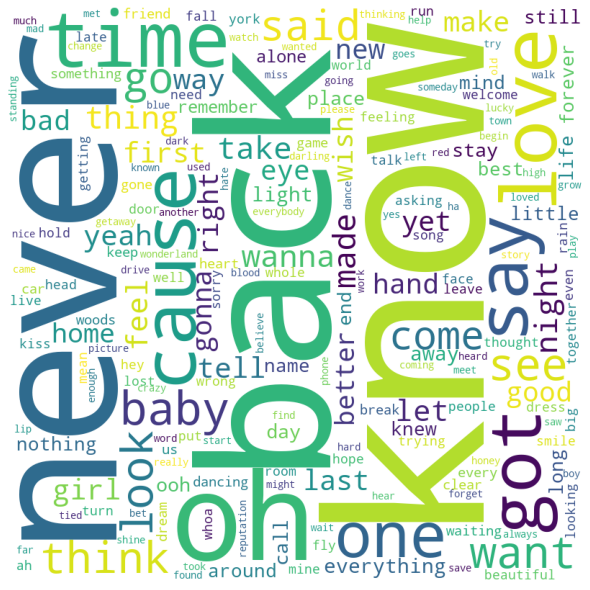

,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,ever,would,love,good,wish,go,night,together,one,ooh
1,2,things,hands,dancing,nice,love,yeah,feeling,said,take,darling
2,3,gonna,could,ever,see,made,hold,best,look,dancing,baby
3,4,one,come,wish,way,love,see,live,long,feeling,would
4,5,want,call,see,baby,everything,would,said,something,way,away
5,6,want,better,last,come,one,whoa,stay,asking,let,see
6,7,new,love,go,still,night,waiting,baby,let,forever,one
7,8,car,mean,first,goes,place,well,us,big,get,old
8,9,got,look,made,baby,go,love,bad,life,home,girl
9,10,wanna,think,love,tell,first,game,would,end,got,good


In [14]:
lyricstokens = textClean.pipeline(lyrics_data['lyrics'].to_list(), multi_gram = [1], lower_case=True, 
                                  deacc=False, encoding='utf8', errors='strict', stem_lemma = '', 
                                  tag_drop = [], nltk_stop=True, stop_word_list=[], 
                                  check_numbers=False, word_length=2, remove_consecutives=True)

print(tfidf.get_top_n_tfidf_bow(lyricstokens, top_n_tokens = 30))
DataExploration.generate_word_cloud(lyricstokens)
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(lyricstokens, num_topics = 10)
lda.lda_topics(lda_allbow)